In [21]:
# !pip install awscli

In [22]:
# import os, requests

# url = "https://isip.piconepress.com/projects/nedc/data/tuh_eeg/tuh_eeg/v2.0.1/edf/000/aaaaaaab/s001_2002_12_30/02_tcp_le/aaaaaaab_s001_t000.edf"
# filename = url.split("/")[-1]

# auth = ('nedc-tuh-eeg', 'L5!Np#8Z$7xJmRpK')

# r = requests.get(url, auth=auth)
# with open(filename, 'wb') as f:
#     f.write(r.content)


In [23]:
# !wget --user="nedc-tuh-eeg" --password="L5!Np#8Z$7xJmRpK" "https://isip.piconepress.com/projects/nedc/data/tuh_eeg/tuh_eeg/v2.0.1/edf/000/00000001.edf"

In [24]:
folders = ["000", "001", "002", "003"]  # add more as needed

base_url = "https://isip.piconepress.com/projects/nedc/data/tuh_eeg/tuh_eeg/v2.0.1/edf/"
username = 'nedc-tuh-eeg'
password = 'L5!Np#8Z$7xJmRpK'

# for folder in folders:
#     !wget --user="{username}" --password="{password}" -r -np -nH --cut-dirs=6 -A .edf {base_url}{folder}/


In [25]:
# !wget --user="nedc-tuh-eeg" --password="L5!Np#8Z$7xJmRpK" https://isip.piconepress.com/projects/nedc/data/tuh_eeg/tuh_eeg/v2.0.1/edf/000/00000001.edf

Extracting EDF parameters from /ihome/cs1671_2025s/vad50/ml/ml-proj-seizures/physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/scratch/slurm-10181/ipykernel_122701/1018265373.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf", preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<RawEDF | chb01_01.edf, 23 x 460800 (3600.0 s), ~80.9 MiB, data loaded>


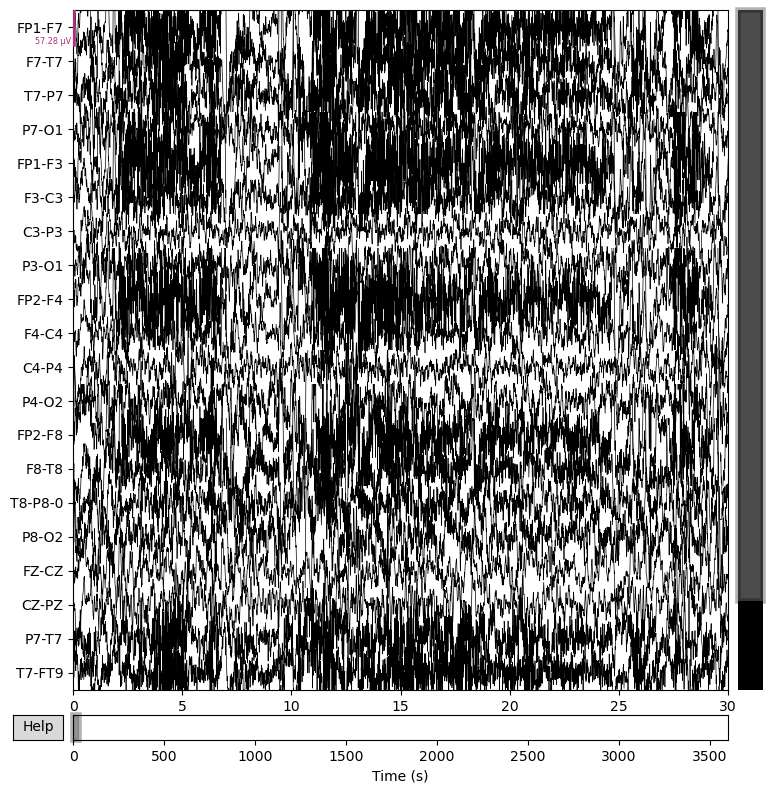

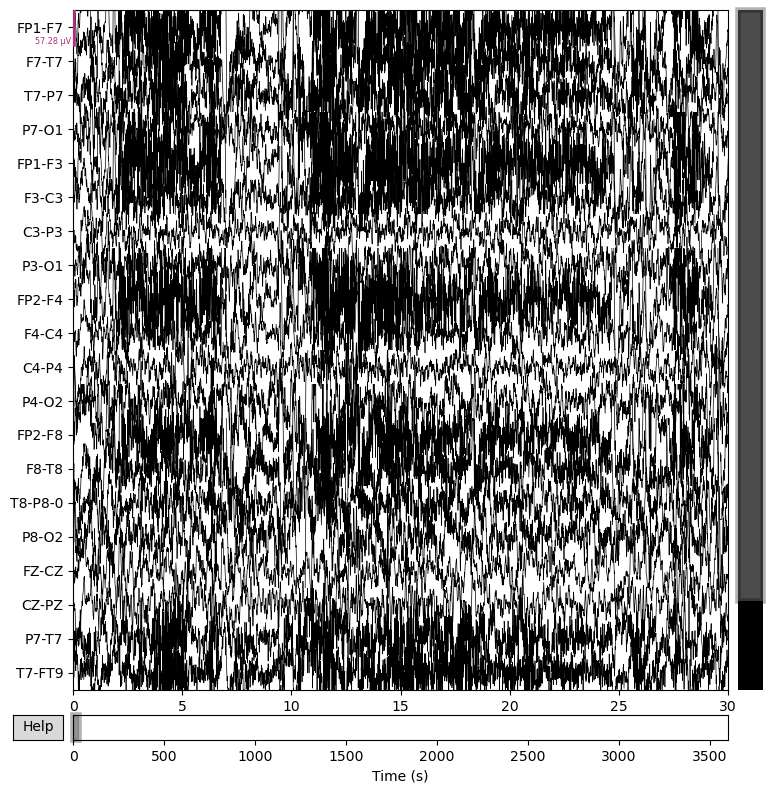

In [26]:
import mne

raw = mne.io.read_raw_edf("physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf", preload=True)

raw.resample(128)
raw.pick_types(eeg=True)
print(raw)
raw.plot(n_channels=20, duration=30, scalings='auto')


In [31]:
# !pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re

def extract_seizure_annotations(base_dir):
    seizure_annotations = defaultdict(list)
    for folder in sorted(os.listdir(base_dir)):
        if folder.startswith("chb"):
            summary_file = os.path.join(base_dir, folder, f"{folder}-summary.txt")
            if not os.path.exists(summary_file):
                continue
                
            print(f"Processing: {summary_file}")
            with open(summary_file) as f:
                lines = f.readlines()
                
            file = None
            for i, line in enumerate(lines):
                line = line.strip()
                
                if line.endswith(".edf"):
                    file = line
                    
                if "Seizure" in line and "Start" in line:
                    # Extract the number using regex to be more robust
                    matches = re.findall(r'(\d+)', line)
                    if matches:
                        start_sec = int(matches[-1])  # Take the last number in the line
                        
                        if i+1 < len(lines) and "Seizure" in lines[i+1] and "End" in lines[i+1]:
                            end_matches = re.findall(r'(\d+)', lines[i+1])
                            if end_matches:
                                end_sec = int(end_matches[-1])
                                if file:  # Make sure we have a file
                                    seizure_annotations[os.path.join(base_dir, folder, file)].append((start_sec, end_sec))
                                    print(f"{file}: {start_sec}s to {end_sec}s")
    
    return seizure_annotations

In [37]:
def load_edf_file(file_path):
    try:
        print(f"Loading {file_path}")
        raw = mne.io.read_raw_edf(file_path, preload=True)
        return raw
    except Exception as e:
        return None

def visualize_eeg(raw, seizure_times=None, duration=30, n_channels=5):
    channels_to_plot = raw.ch_names[:n_channels]
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    start_time = 0
    if seizure_times and len(seizure_times) > 0:
        start_time = max(0, seizure_times[0][0] - duration/2)
    
    data, times = raw.get_data(picks=channels_to_plot, 
                              start=int(start_time * raw.info['sfreq']), 
                              stop=int((start_time + duration) * raw.info['sfreq']), 
                              return_times=True)
    
    offsets = np.arange(len(channels_to_plot)) * 200
    for i, ch_name in enumerate(channels_to_plot):
        ax.plot(times, data[i] + offsets[i], linewidth=0.5)
        ax.text(-0.5, offsets[i], ch_name)
    
    if seizure_times and len(seizure_times) > 0:
        for start, end in seizure_times:
            if start <= start_time + duration and end >= start_time:
                vis_start = max(start, start_time)
                vis_end = min(end, start_time + duration)
                
                ax.axvspan(vis_start, vis_end, color='red', alpha=0.3)
    
    ax.set_yticks([])
    ax.set_xlabel('Time (s)')
    ax.set_title('EEG Recording with Seizure Annotations (if available)')
    
    return fig

In [38]:
def extract_features(raw, window_size=4, overlap=0.5, seizure_times=None):
    sampling_freq = raw.info['sfreq']
    window_samples = int(window_size * sampling_freq)
    step_samples = int((1 - overlap) * window_samples)
    
    data = raw.get_data()
    n_channels, n_samples = data.shape
    
    features = []
    labels = []
    
    for start in range(0, n_samples - window_samples, step_samples):
        end = start + window_samples
        window = data[:, start:end]
        
        start_time = start / sampling_freq
        end_time = end / sampling_freq
        
        is_seizure = 0
        if seizure_times and len(seizure_times) > 0:
            for s_start, s_end in seizure_times:
                if end_time > s_start and start_time < s_end:
                    is_seizure = 1
                    break
        
        window_features = []
        
        for ch in range(n_channels):
            ch_data = window[ch]
            window_features.append(np.mean(ch_data))
            window_features.append(np.std(ch_data))
            window_features.append(np.mean((ch_data - np.mean(ch_data))**3) / (np.std(ch_data)**3 + 1e-10))
            window_features.append(np.mean((ch_data - np.mean(ch_data))**4) / (np.std(ch_data)**4 + 1e-10))
            
            fft_vals = np.abs(np.fft.rfft(ch_data))
            fft_freq = np.fft.rfftfreq(len(ch_data), 1.0/sampling_freq)
            
            delta_mask = (fft_freq >= 0.5) & (fft_freq < 4)
            window_features.append(np.sum(fft_vals[delta_mask]) if np.any(delta_mask) else 0)
            
            theta_mask = (fft_freq >= 4) & (fft_freq < 8)
            window_features.append(np.sum(fft_vals[theta_mask]) if np.any(theta_mask) else 0)
            
            alpha_mask = (fft_freq >= 8) & (fft_freq < 13)
            window_features.append(np.sum(fft_vals[alpha_mask]) if np.any(alpha_mask) else 0)
            
            beta_mask = (fft_freq >= 13) & (fft_freq < 30)
            window_features.append(np.sum(fft_vals[beta_mask]) if np.any(beta_mask) else 0)
            
            gamma_mask = (fft_freq >= 30)
            window_features.append(np.sum(fft_vals[gamma_mask]) if np.any(gamma_mask) else 0)
        
        features.append(window_features)
        labels.append(is_seizure)
    
    return np.array(features), np.array(labels)

In [39]:
class EEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [40]:

class EEGSeizureDetector(nn.Module):
    """Neural network for seizure detection."""
    def __init__(self, input_size):
        super(EEGSeizureDetector, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.model(x)

In [41]:

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return model, train_losses, val_losses

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax)
    
    classes = ['Non-seizure', 'Seizure']
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    return fig

In [42]:
def main(base_dir="physionet.org/files/chbmit/1.0.0/", max_files=5):
    if not os.path.exists(base_dir):
        return
        
    for item in os.listdir(base_dir):
        print(f"  {item}")
    
    seizure_annotations = extract_seizure_annotations(base_dir)
    
    if not seizure_annotations:
        return
    
    seizure_files = [f for f, annot in seizure_annotations.items() if annot]
    
    all_features = []
    all_labels = []
    
    files_processed = 0
    
    for file_path, seizure_times in seizure_annotations.items():
        if not seizure_times or files_processed >= max_files:
            continue
            
        print(f"Processing {file_path}...")
        if not os.path.exists(file_path):
            continue
            
        raw = load_edf_file(file_path)
        if raw is None:
            continue
            
        fig = visualize_eeg(raw, seizure_times)
        plt.savefig(f"eeg_seizure_{files_processed}.png")
        plt.close(fig)
        
        features, labels = extract_features(raw, seizure_times=seizure_times)
        
        if len(features) > 0:
            all_features.append(features)
            all_labels.append(labels)
            print(f"Extracted {len(features)} windows, {sum(labels)} with seizures")
        
        files_processed += 1
    
    non_seizure_files = []
    
    # Check each folder for .edf files not in seizure_annotations
    for folder in [d for d in os.listdir(base_dir) if d.startswith("chb") and os.path.isdir(os.path.join(base_dir, d))]:
        folder_path = os.path.join(base_dir, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".edf"):
                full_path = os.path.join(folder_path, file)
                if full_path not in seizure_annotations:
                    non_seizure_files.append(full_path)
    
    
    for file_path in non_seizure_files[:max_files - files_processed]:
        if not os.path.exists(file_path):
            continue
            
        raw = load_edf_file(file_path)
        if raw is None:
            continue
            
        fig = visualize_eeg(raw)
        plt.savefig(f"eeg_non_seizure_{files_processed}.png")
        plt.close(fig)
        
        features, labels = extract_features(raw)
        
        if len(features) > 0:
            all_features.append(features)
            all_labels.append(labels)
            print(f"Extracted {len(features)} windows without seizures")
        
        files_processed += 1
    
    if not all_features:
        return
    
    try:
        combined_features = np.vstack(all_features)
        combined_labels = np.concatenate(all_labels)
    except ValueError as e:
        print(f"Feature shapes: {[f.shape for f in all_features]}")
        return
    
    print(f"Dataset - Total windows: {len(combined_labels)}, Seizure windows: {sum(combined_labels)}")
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)
    
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, combined_labels, test_size=0.2, random_state=42, stratify=combined_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
    )
    
    train_dataset = EEGDataset(X_train, y_train)
    val_dataset = EEGDataset(X_val, y_val)
    test_dataset = EEGDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    

    input_size = X_train.shape[1]
    model = EEGSeizureDetector(input_size)
    trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('training_curves.png')
    
    cm_fig = evaluate_model(trained_model, test_loader)
    plt.savefig('confusion_matrix.png')
    
    return trained_model, scaler

if __name__ == "__main__":
    main()

Step 1: Extracting seizure annotations...
Contents of base directory 'physionet.org/files/chbmit/1.0.0/':
  chb02
  chb03
  chb15
  chb22
  chb24
  chb01
  RECORDS
  chb10
  chb07
  chb13
  RECORDS-WITH-SEIZURES
  chb08
  index.html
  SHA256SUMS.txt
  chb23
  shoeb-icml-2010.pdf
  chb06
  chb19
  chb11
  chb20
  ANNOTATORS
  chb12
  chb21
  chb05
  chb16
  chb04
  chb09
  SUBJECT-INFO
  chb14
  chb17
  chb18
Processing summary file: physionet.org/files/chbmit/1.0.0/chb01/chb01-summary.txt
Added seizure for File Name: chb01_03.edf: 2996s to 3036s
Added seizure for File Name: chb01_04.edf: 1467s to 1494s
Added seizure for File Name: chb01_15.edf: 1732s to 1772s
Added seizure for File Name: chb01_16.edf: 1015s to 1066s
Added seizure for File Name: chb01_18.edf: 1720s to 1810s
Added seizure for File Name: chb01_21.edf: 327s to 420s
Added seizure for File Name: chb01_26.edf: 1862s to 1963s
Found 7 files with seizure annotations
Found 7 files with seizures
Step 2: Processing EDF files and ex

/scratch/slurm-10181/ipykernel_122701/3651665814.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Successfully loaded: 23 channels, 921600 samples
Extracted 1798 windows, all without seizures
Processing non-seizure file physionet.org/files/chbmit/1.0.0/chb01/chb01_05.edf...
Loading EDF file: physionet.org/files/chbmit/1.0.0/chb01/chb01_05.edf
Extracting EDF parameters from /ihome/cs1671_2025s/vad50/ml/ml-proj-seizures/physionet.org/files/chbmit/1.0.0/chb01/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/scratch/slurm-10181/ipykernel_122701/3651665814.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Successfully loaded: 23 channels, 921600 samples
Extracted 1798 windows, all without seizures
Processing non-seizure file physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf...
Loading EDF file: physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf
Extracting EDF parameters from /ihome/cs1671_2025s/vad50/ml/ml-proj-seizures/physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/scratch/slurm-10181/ipykernel_122701/3651665814.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Successfully loaded: 23 channels, 921600 samples
Extracted 1798 windows, all without seizures
Processing non-seizure file physionet.org/files/chbmit/1.0.0/chb01/chb01_06.edf...
Loading EDF file: physionet.org/files/chbmit/1.0.0/chb01/chb01_06.edf
Extracting EDF parameters from /ihome/cs1671_2025s/vad50/ml/ml-proj-seizures/physionet.org/files/chbmit/1.0.0/chb01/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/scratch/slurm-10181/ipykernel_122701/3651665814.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Successfully loaded: 23 channels, 921600 samples
Extracted 1798 windows, all without seizures
Processing non-seizure file physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf...
Loading EDF file: physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf
Extracting EDF parameters from /ihome/cs1671_2025s/vad50/ml/ml-proj-seizures/physionet.org/files/chbmit/1.0.0/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/scratch/slurm-10181/ipykernel_122701/3651665814.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Successfully loaded: 23 channels, 921600 samples
Extracted 1798 windows, all without seizures
Dataset - Total windows: 8990, Seizure windows: 0
Step 3: Training model...
Epoch 1/20, Train Loss: 0.0550, Val Loss: 0.0001, Val Acc: 100.00%
Epoch 2/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 3/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 4/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 5/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 6/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 7/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 8/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 9/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 10/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 11/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 12/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 100.00%
Epoch 13/20, Train Loss

/ihome/cs1671_2025s/vad50/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1